In [ ]:
"""
Compare the output of our wind model (Holland, downscaled with local surface roughness)
against the footprints of Done et al. (Willougby with numerical boundary layer simulation)
"""

In [2]:
import contextily as cx
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import shapely

import os
from glob import glob

In [3]:
def grid_point_data(point_speeds: gpd.GeoDataFrame, col_name: str, agg_func_name: str, delta: float = 0.1) -> gpd.GeoDataFrame:
    """
    Bin data on a regular grid. Grid will snap to integer number of `delta` from CRS reference.
    
    Args:
        point_speeds: Table of data at point locations
        col_name: Data column to rebin
        agg_func: Name of function to apply to multiple points within a bin, e.g. max, mean
        delta: Width and height of output raster pixels in decimal degrees
    """
    
    def n_cells(start: float, end: float, width: float) -> int:
        return round((end - start) / width)

    # create grid

    # unpack and snap extrema to integer number of cells from CRS reference
    min_x, min_y, max_x, max_y = map(lambda x: np.ceil(x / delta) * delta, point_speeds.total_bounds)

    cells = []
    for x0 in np.linspace(min_x, max_x, n_cells(min_x, max_x, delta) + 1):
        x1 = x0 + delta
        for y0 in np.linspace(min_y, max_y, n_cells(min_y, max_y, delta) + 1):
            y1 = y0 + delta
            cells.append(shapely.geometry.box(x0, y0, x1, y1))

    grid = gpd.GeoDataFrame({"geometry": cells})

    # associate points with grid
    raster = grid.sjoin(point_speeds, how="inner")

    # take aggregate of arbitrary number of rows (points) grouped by cell
    agg_func = getattr(raster.groupby(raster.index), agg_func_name)
    aggregated = agg_func(col_name)
    
    # merge geometry back in, how="right" for every grid cell, empty or not
    rebinned = aggregated.merge(grid[["geometry"]], left_index=True, right_index=True, how="right")
    rebinned = rebinned.drop(columns=["index_right"])
    
    # cast to GeoDataFrame again (merge reverted to DataFrame) and return
    return gpd.GeoDataFrame(rebinned)

In [4]:
def to_xarray(cells: gpd.GeoDataFrame) -> xr.Dataset:
    """
    Given table of polygon cells, export to xarray
    """
    to_export = cells
    to_export["longitude"] = to_export.geometry.centroid.x
    to_export["latitude"] = to_export.geometry.centroid.y
    to_export = to_export.drop(columns=["geometry"])
    to_export = to_export.set_index(["longitude", "latitude"])
    return to_export.to_xarray()

In [5]:
def read_kw01(name_year: str, delta: float) -> gpd.GeoDataFrame:
    """
    Read the KW01 data, wrangle as points in GeoDataFrame
    
    Args:
        name_year: Storm identifier, e.g. IRMA_2017 or IKE_2008
        delta: Grid resolution to return at in decimal degrees
    """
    
    data = pd.concat(
        [
            pd.read_csv(path, delimiter=r',\s+')
            for path in glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/{name_year}/*.txt")
        ]
    )
    point_speeds = gpd.GeoDataFrame(
        {
            "max_wind_speed": data["wind(m/s)"],
            "geometry": gpd.points_from_xy(data.lon, data.lat)
        }
    )

    return to_xarray(grid_point_data(point_speeds, "max_wind_speed", "max", delta=delta))

In [6]:
def fig_size(
    min_x: float,
    min_y: float,
    max_x: float,
    max_y: float,
    max_width_in: float = 16,
    max_height_in: float = 9
) -> tuple[float, float]:
    """
    Given bounding box, calculate size of figure in inches for equal aspect ratio.
    
    Returns:
        width in inches, height in inches
    """
    x_span = max_x - min_x
    y_span = max_y - min_y
    aspect_ratio = y_span / x_span
    max_plot_width_in = 16
    max_plot_height_in = 9

    if max_plot_width_in * aspect_ratio < max_plot_height_in:
        # tall
        x_in = max_plot_width_in
        y_in = max_plot_width_in * aspect_ratio

    else:
        # wide
        x_in = max_plot_height_in / aspect_ratio
        y_in = max_plot_height_in
        
    return x_in, y_in

In [7]:
def name_year_from_id(tracks: gpd.GeoDataFrame, storm_id: str) -> str:
    """
    Given IBTrACS storm ID, return name_year.
    e.g. "2017242N16333" -> "IRMA_2017"
    """
    storm_track = tracks[tracks.track_id==storm_id]
    track_point = storm_track.iloc[0]
    name = track_point["name"]
    year = track_point["year"]
    return f"{name}_{year}"

def id_from_name_year(tracks: gpd.GeoDataFrame, name_year: str) -> str | None:
    """
    Given name_year, return IBTrACS storm ID.
    e.g. "IRMA_2017" -> "2017242N16333"
    """
    try:
        name, year = name_year.split("_")
    except ValueError:
        print(f"skipping {name_year}...")
        return None
    track = tracks[(tracks.name==name) & (tracks.year==int(year))]
    try:
        storm_id, = set(track.track_id)
    except ValueError:
        print(f"{name_year} is ambiguous: {set(track.track_id)}, skipping...")
        return None
    return storm_id

In [8]:
def map_ratio(field_ratio: xr.DataArray, storm_track: gpd.GeoDataFrame, storm_id: str, plot_dir: str):
    """
    Plot a DataArray of the ratio of two wind fields.
    Uses diverging colourmap centered around 1.
    """
    
    f, ax = plt.subplots(
        figsize=fig_size(
            field_ratio.longitude.min(),
            field_ratio.latitude.min(),
            field_ratio.longitude.max(),
            field_ratio.latitude.max()
        )
    )

    divider = make_axes_locatable(ax)
    ratio_cax = divider.append_axes("right", size="2%", pad=0.05)
    xr.plot.pcolormesh(
        field_ratio,
        x="longitude",
        y="latitude",
        cmap="bwr",
        levels=np.linspace(0, 2, 10),
        extend="neither",
        alpha=0.5,
        ax=ax,
        cbar_ax=ratio_cax
    )
    ratio_cax.set_ylabel(r"$\frac{\mathrm{Downscaled \ Holland}}{\mathrm{Kepert \ Wang \ 2001}}$", labelpad=10)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{storm_id.replace('_', ', ')}")
    
    min_x, max_x = ax.get_xlim()
    min_y, max_y = ax.get_ylim()
    
    track_cax = divider.append_axes("right", size="2%", pad=1)
    storm_track.plot(
        ax=ax,
        column="max_wind_speed_ms",
        cmap="viridis",
        alpha=1,
        vmin=0,
        vmax=80,
        legend=True,
        legend_kwds={
            "label": "IBTrACS maximum wind speed [ms-1]",
            "cax": track_cax
        }
    )
    
    cx.add_basemap(
        ax,
        crs=storm_track.crs.to_string(),
        source=cx.providers.Stamen.TonerLite
    )

    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    
    ax.grid(alpha=0.3)
    
    f.savefig(os.path.join(plot_dir, f"{storm_id}.png"))
    plt.close(f)
    
    return

In [11]:
def clip_field_buffer_landfalling_points(
    storm_track: gpd.GeoDataFrame,
    field: xr.DataArray,
    buffer_radius_km: float
) -> np.ndarray:
    """
    Return the ratio values from `field` within a certain distance of points in `storm_track`
    """
    
    # make a buffer around the on-land track points
    land_track = storm_track[storm_track.landfall == True]
    land_track_3857 = land_track.to_crs(3857)
    buffer = land_track_3857.buffer(buffer_radius_km * 1000).to_crs(4326)
    land_track.loc[:, "geometry"] = buffer

    # get the field as gpd points
    df = field.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
        {
            "measure": df.max_wind_speed,
            "geometry": gpd.points_from_xy(df.longitude, df.latitude)
        }                                
    ).set_crs(4326)

    # find the intersection
    buffered_values_gdf = gdf.sjoin(land_track, how="inner")
    
    return buffered_values_gdf.measure.values

In [112]:
def plot_error(
    errors: np.ndarray,
    buffer_km: float,
    filepath: str
) -> None:
    """
    Plot distribution of wind speed errors w.r.t Done et al.
    
    pooled_ratio: 1D array of ratios to bin.
    """

    f, ax = plt.subplots(figsize=(8, 5))

    mean = np.nanmean(errors)
    median = np.nanmedian(errors)
    n = len(errors)

    ax.set_title(
        (
            "Wind model validation against Done et al.\n"
            f"for pixels < {buffer_km}km from eye\n"
            f"$n_{{pixels}}={n}, \ \mu={mean:.2f} $ms$^{{-1}}, \ q_{{50}}={median:.2f}$ms$^{{-1}}$"
        ),
        pad=15
    )
    ax.set_xlabel("Errors: downscaled Holland $-$ Done et al. [ms$^{-1}$]", labelpad=10)
    ax.set_ylabel("Frequency", labelpad=10)

    frequency, bin_edges, _ = ax.hist(
        errors,
        bins=np.linspace(-100, 100, 201),
        color="g",
        alpha=0.5,
        density=True,
        label="PDF"
    )

    ax.axvline(mean, color="r", ls="--", label="Mean", alpha=0.5)
    miny, maxy = ax.get_ylim()
    for probability_level in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
        quantile = np.quantile(errors, probability_level)
        ax.axvline(quantile, color="pink", ls="--", alpha=0.6)
        ax.text(
            quantile,
            0.07 * maxy,
            f"$\mathrm{{q}}_{{{probability_level:.2f}}}$",
            rotation=-90,
            ha="center",
            size=9
        )

    ax.set_xlim(-20, 20)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.subplots_adjust(top=0.8, bottom=0.15)

    f.savefig(filepath)
    plt.close(f)

In [12]:
tracks = gpd.read_parquet(
    "/home/fred/projects/open_gira/open-gira/results/storm_tracks/IBTrACS/tracks.geoparquet"
)
holland_storms_id = {
    path.split("/")[-1] for path in
    glob("/home/fred/projects/open_gira/open-gira/results/power/by_storm_set/IBTrACS/by_storm/*")
}
holland_storms_name_year = {
    name_year_from_id(tracks, storm_id) for storm_id in
    holland_storms_id
}
wrn_storms_name_year = {
    path.split("/")[-2] for path in
    glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/*/*.txt")
}
common_storms_name_year = holland_storms_name_year & wrn_storms_name_year
common_storms_id = [
    id_from_name_year(tracks, name_year)
    for name_year in common_storms_name_year
]
common_storms = sorted(filter(bool, common_storms_id))

print(f"{len(holland_storms_name_year)=}")
print(f"{len(wrn_storms_name_year)=}")
print(f"{len(common_storms)=}")

TOMAS_2010 is ambiguous: {'2010302N09306', '2010069S12188'}, skipping...
skipping NOT_NAMED_2002...
skipping NOT_NAMED_2017...
skipping NOT_NAMED_2006...
skipping NOT_NAMED_2014...
PODUL_2019 is ambiguous: {'2019237N08140', '2019236N08143'}, skipping...
skipping NOT_NAMED_2007...
skipping NOT_NAMED_2011...
skipping NOT_NAMED_2010...
skipping NOT_NAMED_2003...
skipping NOT_NAMED_2013...
HARVEY_2005 is ambiguous: {'2005215N28291', '2005035S14136'}, skipping...
skipping NOT_NAMED_2016...
skipping NOT_NAMED_2005...
JOYCE_2018 is ambiguous: {'2018007S13130', '2018255N37320'}, skipping...
len(holland_storms_name_year)=1219
len(wrn_storms_name_year)=743
len(common_storms)=577


In [55]:
buffer_km = 300

plot_dir_frames = (
    "/home/fred/projects/open_gira/open-gira/validation/holland_done_ratio/"
    f"buffer-km-{int(buffer_km)}"
)
os.makedirs(plot_dir_frames, exist_ok=True)

# store the ratios for later
errors_by_storm = {}
for i, storm_id in enumerate(common_storms[:10]):

    name_year = name_year_from_id(tracks, storm_id)
    storm_track = tracks[tracks.track_id == storm_id]

    # filter out weak storms for speed
    if storm_track.max_wind_speed_ms.max() < 20:
        print(f"{name_year} has {storm_track.max_wind_speed_ms.max()}, skipping...")
        continue

    try:
        kw01 = (
            read_kw01(name_year, delta=0.1)
                .interpolate_na(dim="longitude", method="linear")
                .interpolate_na(dim="latitude", method="linear")
        )
    except ValueError:
        print(f"couldn\'t read kw01 for {name_year}, skipping...")
        continue
    try:
        holland = xr.open_dataset(
            (
                "/home/fred/projects/open_gira/open-gira/"
                f"results/power/by_storm_set/IBTrACS/by_storm/{storm_id}/wind_field.nc"
            )
        )
    except FileNotFoundError:
        print(f"couldn\'t find holland for {name_year}, skipping...")
        continue

    try:
        difference = (holland - kw01).max_wind_speed
        ratio = (holland / kw01).max_wind_speed
    except ValueError:
        print(f"couldn\'t calculate the difference for {name_year}, skipping...")
        continue

    # make a buffer around the on-land track      
    print(name_year)
    print(storm_id)
    errors_by_storm[storm_id] = clip_field_buffer_landfalling_points(storm_track, difference, buffer_km)

#     map_ratio(
#         ratio,
#         storm_track,
#         f"{name_year}_{storm_id}",
#         "/home/fred/projects/open_gira/open-gira/validation/plots/wind_fields/"
#     )

    print(f"{len(errors_by_storm)=} storms compared...")
    errors = np.concatenate(list(errors_by_storm.values()))
    errors = errors[~np.isnan(errors)]            
    print(f"{len(errors)=} pixel-wise comparisons...")
    if len(errors) == 0:
        print("no data, skipping...")
        continue

    print("plotting distribution...")
    plot_error(
        errors,
        buffer_km,
        os.path.join(
            plot_dir_frames,
            f"{i:04d}.png"
        )
    )

print("saving ratios to disk...")
basename = f"buffer-km-{buffer_km}"
plot_dir = "/home/fred/projects/open_gira/open-gira/validation/holland_done_ratio"
data_filepath = os.path.join(plot_dir, basename + ".npy")
np.save(data_filepath, errors)

print("plotting distribution...")
plot_error(
    errors,
    buffer_km,
    os.path.join(plot_dir, basename + ".png")
)

print("animating convergence...")
frame_filepaths = glob(os.path.join(plot_dir_frames, "*.png"))
os.system(
    "convert -delay 5 "
    f"{' '.join(sorted(frame_filepaths))} "
    f"{os.path.join(plot_dir, basename)}.gif"
)

/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALLISON_2001
len(residuals_by_storm)=1 storms compared...
len(residuals)=5093 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


YUTU_2001
len(residuals_by_storm)=2 storms compared...
len(residuals)=5093 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


couldn't find holland for TORAJI_2001, skipping...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARRY_2001
len(residuals_by_storm)=3 storms compared...
len(residuals)=7807 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PABUK_2001
len(residuals_by_storm)=4 storms compared...
len(residuals)=16288 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DEAN_2001
len(residuals_by_storm)=5 storms compared...
len(residuals)=16288 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FITOW_2001
len(residuals_by_storm)=6 storms compared...
len(residuals)=23527 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANAS_2001
len(residuals_by_storm)=7 storms compared...
len(residuals)=28906 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NARI_2001
len(residuals_by_storm)=8 storms compared...
len(residuals)=53426 pixel-wise comparisons...
plotting distribution...


/tmp/ipykernel_3720926/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GABRIELLE_2001
len(residuals_by_storm)=9 storms compared...
len(residuals)=62404 pixel-wise comparisons...
plotting distribution...
saving ratios to disk...
plotting distribution...
animating convergence...


0

In [143]:
# make a buffer around the on-land track points
land_track = storm_track[storm_track.landfall == True]
land_track_3857 = land_track.to_crs(3857)
buffer = land_track_3857.buffer(300 * 1000).to_crs(4326)
# get the unary_union of track point buffers
aoi = gpd.GeoDataFrame(geometry=[buffer.unary_union])

# get the field as gpd points
df = difference.to_dataframe().reset_index()
gdf = gpd.GeoDataFrame(
    {
        "measure": df.max_wind_speed,
        "geometry": gpd.points_from_xy(df.longitude, df.latitude)
    }                                
).set_crs(4326)

# find the field values within the AOI
buffered_values_gdf = gdf.sjoin(aoi, how="inner")

# recast as xarray field
field = buffered_values_gdf[["measure", "geometry"]].copy()
field.geometry = field.geometry.drop_duplicates()
field["latitude"] = field.geometry.y
field["longitude"] = field.geometry.x
field = field.drop(columns=["geometry"])
field = field.set_index(["longitude", "latitude"])
field = field.to_xarray()

/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


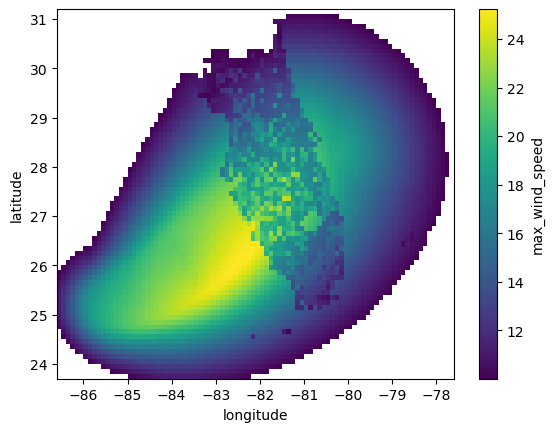

In [144]:
xr.plot.pcolormesh(holland.max_wind_speed, x="longitude")

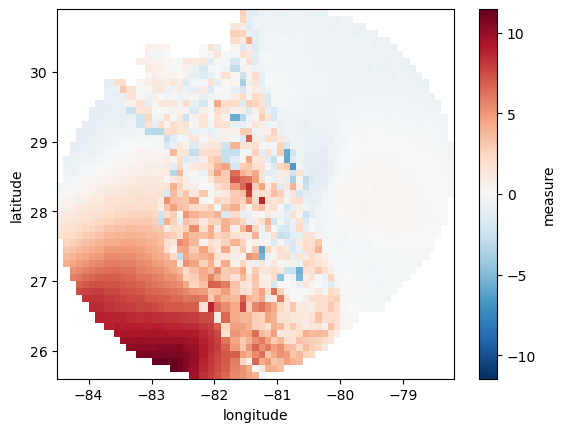

In [145]:
xr.plot.pcolormesh(field.measure, x="longitude")

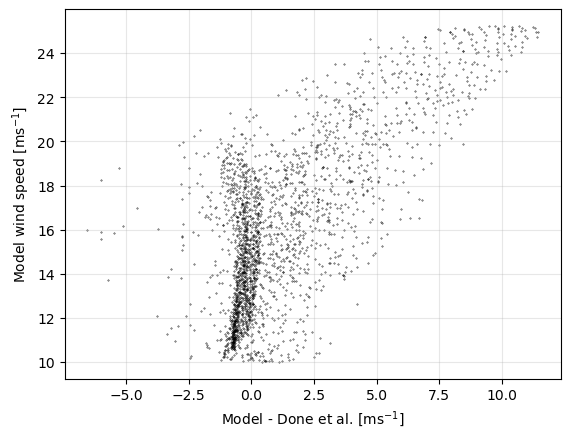

In [151]:
model = holland.sel(
    dict(
        longitude=field.longitude,
        latitude=field.latitude
    )
).max_wind_speed.values.ravel()
error = field.measure.values.ravel()

f, ax = plt.subplots()
ax.scatter(error, model, s=0.1, c="k")
ax.set_ylabel("Model wind speed [ms$^{-1}$]")
ax.set_xlabel("Model - Done et al. [ms$^{-1}$]")
ax.grid(alpha=0.3)